# import libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import pandas as pd
import warnings
warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout")


# Load dataset

In [2]:
data = pd.read_csv('grlc_io_reponse_get_datasets_with_ct.csv')
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None) 
print(data.head())

  source                                                                                                                   dataset  organ                       as                                         as_iri  age     sex   bmi        tool   cell_type cell_type_label  cell_type_count  cell_type_percentage biomarker_label  mean_expression_value
0    HCA    https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H5$left%20cardiac%20atrium  heart      left cardiac atrium  http://purl.obolibrary.org/obo/UBERON_0002079   50  Female  20.0  celltypist  CL:0000136           Adip1              161              0.073600           ACSL1               2.067057
1    HCA    https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H5$left%20cardiac%20atrium  heart      left cardiac atrium  http://purl.obolibrary.org/obo/UBERON_0002079   50  Female  20.0  celltypist  CL:0000136           Adip1              161              0.07360

# Group by 'as' and 'biomarker_label' and calculate mean values

In [3]:
subset_data = data.groupby(['as', 'biomarker_label']).agg({
    'cell_type_percentage': 'mean',
    'mean_expression_value': 'mean'
}).reset_index()

biomarker_order = subset_data.groupby('biomarker_label')['mean_expression_value'].mean().sort_values(ascending=False).index
print(biomarker_order)

Index(['MALAT1', 'ENSG00000278996.1', 'ENSG00000280441.3', 'LAMA2', 'NEAT1', 'RGS5', 'MT-CO1', 'PRKG1', 'RPS7', 'CD36',
       ...
       'MDFIC', 'COLEC12', 'SLC16A4', 'TMBIM4', 'EPB41L3', 'PPP2R1B', 'FAM13A', 'CALCRL', 'PTPRF', 'ADAMTS12'], dtype='object', name='biomarker_label', length=444)


# Reorder subset_data based on new biomarker_label order
Before visualizing the data, it's important to sort the `subset_data` based on a meaningful order of the `biomarker_label`. Sorting biomarkers by their average expression values across the dataset, allows the dot plot to convey biological insights more effectively, highlighting which biomarkers are more prominently expressed across different cell types or conditions.


The ordering process involves:
1. Grouping `subset_data` by `biomarker_label` and calculating the mean expression value for each biomarker.
2. Sorting the `biomarker_label`s based on these mean values in descending order, prioritizing biomarkers with higher overall expression.
3. Applying this sorted order back to `subset_data`, ensuring the visualization accurately reflects biomarkers' hierarchical expression levels.

In [5]:
subset_data['biomarker_label'] = pd.Categorical(subset_data['biomarker_label'], categories=biomarker_order, ordered=True)
subset_data = subset_data.sort_values('biomarker_label')
print(subset_data)

                                                                     as biomarker_label  cell_type_percentage  mean_expression_value
887                                                 left cardiac atrium          MALAT1              0.003268               6.921847
773                                             interventricular septum          MALAT1              0.004791               5.430481
958                                                right cardiac atrium          MALAT1              0.004567               6.913639
272                                                heart left ventricle          MALAT1              0.003293               4.599200
42   Posteromedial head of posterior papillary muscle of left ventricle          MALAT1              0.006955               6.271021
..                                                                  ...             ...                   ...                    ...
805                                             interventricular sept

# Create plot
This section is dedicated to creating a visualization that highlights the intricate relationships between anatomical structures and biomarkers. Our focus is to illustrate how biomarker expression varies across different anatomical structures, using both mean gene expression values and the percentage of cells expressing each biomarker.

**1. Preparing the Data**

We start by restructuring our dataset into two pivot tables: `pivot_count` and `pivot_percentage`. These tables reorganize our data to facilitate a straightforward comparison of biomarker expressions across various anatomical structures. The `pivot_count` table focuses on the mean gene expression values, while `pivot_percentage` highlights the proportion of cells within each anatomical structure that express each biomarker.

**2. Setting up the visualization**

We normalize the data to ensure consistent color mapping across the range of mean gene expression values and cell expression percentages. The `cubehelix_palette` from seaborn provides a color map that helps differentiate between higher and lower values through color intensity.

**3. Plotting the data**

We create the scatter plot, where each dot represents a unique combination of anatomical structure and biomarker. The color and size of each dot are determined by the mean gene expression value and the percentage of cells expressing the biomarker, respectively.

**4. Enhancing plot readability**

Adjusting the plot's aesthetic elements, such as tick labels, grid lines, and margins, ensure that the plot remains uncluttered and that each component is visible and legible.

**5. Adding legends**

The legends for point sizes and the color bar for mean gene expression provide context, making the plot informative and self-explanatory.

**6. Final Adjustments**

Final layout adjustments are made to ensure that all elements of the plot are well-spaced and clearly visible. This step addresses any remaining layout issues, ensuring that the visualization is both aesthetically pleasing and informative.

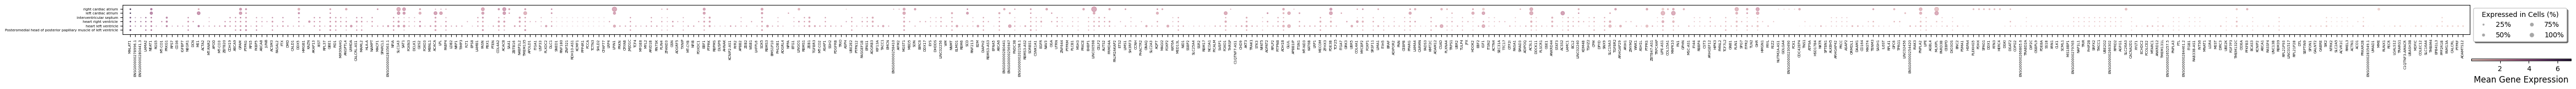

In [5]:
# Create pivot tables for mean gene expression values and cell expression percentages by biomarker across anatomical structures
pivot_count = subset_data.pivot(index='as', columns='biomarker_label', values='mean_expression_value')
pivot_percentage = subset_data.pivot(index='as', columns='biomarker_label', values='cell_type_percentage')

# Normalize color mapping and size mapping
norm_count = Normalize(vmin=pivot_count.min().min(), vmax=pivot_count.max().max())
max_size = 50  # Maximum point size (squared points)
max_percentage = pivot_percentage.max().max()
norm_percentage = Normalize(vmin=0, vmax=max_percentage, clip=True)

# Create color map
cmap = sns.cubehelix_palette(as_cmap=True)

# Create figure and scatter plot
fig, ax = plt.subplots(figsize=(50, 2))

# Plot each point, size and color based on normalized values
for i, as_value in enumerate(pivot_count.index):
    for j, biomarker_label in enumerate(pivot_count.columns):
        count = pivot_count.loc[as_value, biomarker_label]
        percentage = pivot_percentage.loc[as_value, biomarker_label]
        size = (norm_percentage(percentage) * max_size) if not np.isnan(percentage) else 0
        if size > 0:
            ax.scatter(j, i, color=cmap(norm_count(count)), s=size, alpha=0.7)

# Set axis labels and ticks
ax.set_xticks(np.arange(len(pivot_count.columns)))
ax.set_xticklabels(pivot_count.columns, rotation=90)
ax.set_yticks(np.arange(len(pivot_count.index)))
ax.set_yticklabels(pivot_count.index)

# Reduce the font size of both x-axis and y-axis tick labels to half of the current default size for improved plot readability
current_font_size = plt.rcParams['font.size']
ax.tick_params(axis='x', labelsize=current_font_size * 0.5)
ax.tick_params(axis='y', labelsize=current_font_size * 0.5)

# Disable the grid lines on the plot for a cleaner visual appearance
ax.grid(False)

# Set minimal x-axis margin and significantly increase y-axis margin for better layout spacing
ax.margins(x=0.003,y=0.2) 

# Create legend for point sizes
sizes = [0.25 * max_size, 0.5 * max_size, 0.75 * max_size, max_size]
labels = ['25%', '50%', '75%', '100%']
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor='grey', markersize=np.sqrt(size), alpha=0.7) for size, label in zip(sizes, labels)]
legend1 = ax.legend(handles=legend_elements, title="Expressed in Cells (%)", loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, shadow=True, ncol=2)
ax.add_artist(legend1)

# Create color bar legend
sm = ScalarMappable(cmap=cmap, norm=norm_count)
cbar_ax = fig.add_axes([0.995, 0.3, 0.04, 0.02])  
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Mean Gene Expression', fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  
plt.tight_layout(pad=2)
